In [ ]:
!pip install trimesh

In [2]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

In [4]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473407488/473402300 [==============================] - 11s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

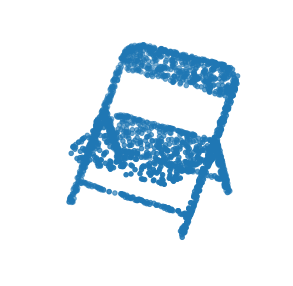

In [6]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [7]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

with tf.device('/GPU:0'):
  NUM_POINTS = 2048
  NUM_CLASSES = 10
  BATCH_SIZE = 32

  train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
      NUM_POINTS
  )

processing class: table
processing class: chair
processing class: bathtub
processing class: toilet
processing class: dresser
processing class: sofa
processing class: monitor
processing class: bed
processing class: desk
processing class: night_stand


In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [10]:
with tf.device('/GPU:0'):
  model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      metrics=["sparse_categorical_accuracy"],
  )

  model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
125/125 [==============================] - 47s 100ms/step - loss: 3.9954 - sparse_categorical_accuracy: 0.2355 - val_loss: 214483.2500 - val_sparse_categorical_accuracy: 0.1377
Epoch 2/30
125/125 [==============================] - 12s 94ms/step - loss: 3.2635 - sparse_categorical_accuracy: 0.3331 - val_loss: 9175548559360.0000 - val_sparse_categorical_accuracy: 0.2731
Epoch 3/30
125/125 [==============================] - 12s 93ms/step - loss: 2.9058 - sparse_categorical_accuracy: 0.4228 - val_loss: 39701.0820 - val_sparse_categorical_accuracy: 0.2863
Epoch 4/30
125/125 [==============================] - 12s 94ms/step - loss: 2.7373 - sparse_categorical_accuracy: 0.4812 - val_loss: 1365347425971077120.0000 - val_sparse_categorical_accuracy: 0.4868
Epoch 5/30
125/125 [==============================] - 12s 94ms/step - loss: 2.5588 - sparse_categorical_accuracy: 0.5182 - val_loss: 152246339764224.0000 - val_sparse_categorical_accuracy: 0.5441
Epoch 6/30
125/125 [================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Balanced accuracy score: 0.9541666666666666
Recall score: 0.90625
Precision score: 0.90625
F1 score: 0.90625
              precision    recall  f1-score   support

       table       0.50      1.00      0.67         2
       chair       1.00      1.00      1.00         2
     bathtub       1.00      1.00      1.00         1
      toilet       1.00      1.00      1.00         3
     dresser       1.00      0.88      0.93         8
        sofa       0.67      1.00      0.80         2
     monitor       1.00      1.00      1.00         3
         bed       1.00      1.00      1.00         3
        desk       1.00      0.67      0.80         6
 night_stand       1.00      1.00      1.00         2

    accuracy                           0.91        32
   macro avg       0.92      0.95      0.92        32
weighted avg       0.95      0.91      0.91        32



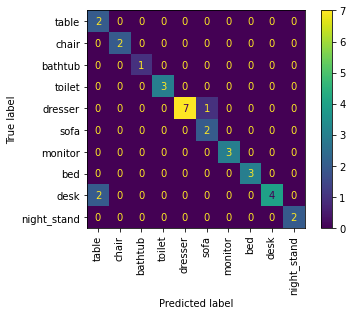

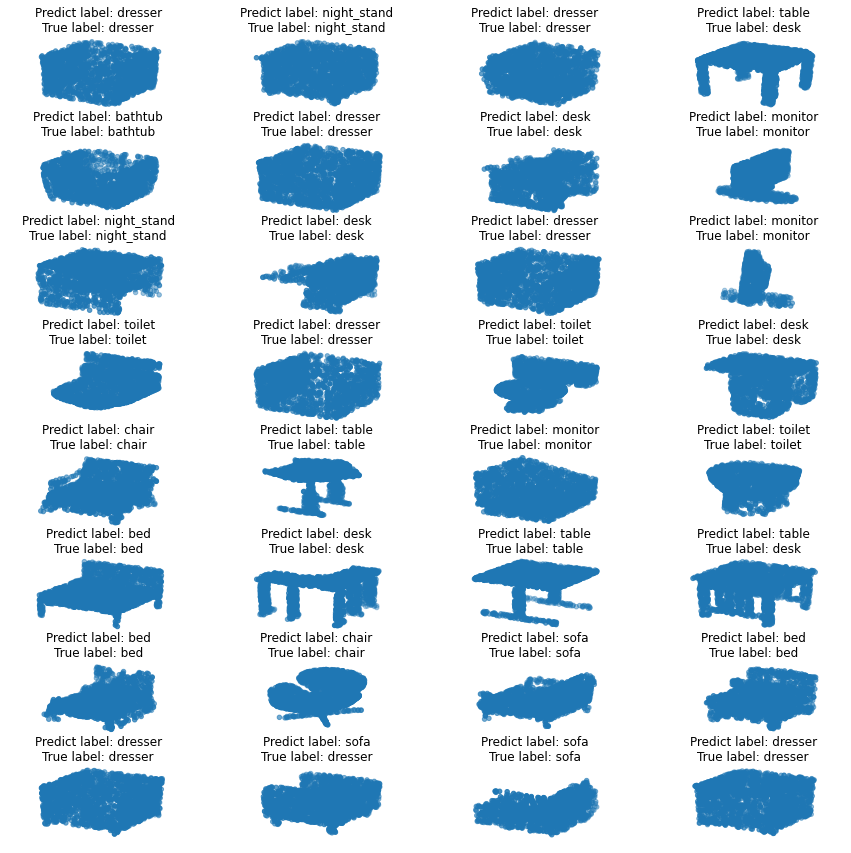

In [106]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

with tf.device('/GPU:0'):
  data = test_dataset.take(1)

  points, labels = list(data)[0]
  points = points[:32, ...]
  labels = labels[:32, ...]

  # run test data through model
  preds = model.predict(points)
  preds = tf.math.argmax(preds, -1)

  points = points.numpy()

  predict_classes = labels.numpy()
  true_classes = preds.numpy()

  conf = confusion_matrix(true_classes, predict_classes)

  disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                display_labels=CLASS_MAP.values())
  disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical', values_format=None, ax=None) 


  balanced_accuracy = balanced_accuracy_score(true_classes, predict_classes)
  precision_recall_fscore = precision_recall_fscore_support(true_classes, predict_classes, pos_label='positive', average='micro')

  print('Balanced accuracy score: {}'.format(balanced_accuracy))
  print('Recall score: {}'.format(precision_recall_fscore[0]))
  print('Precision score: {}'.format(precision_recall_fscore[1]))
  print('F1 score: {}'.format(precision_recall_fscore[2]))
  
  true_labels = list(map(lambda tr_class: CLASS_MAP[tr_class], true_classes))
  predict_labels = list(map(lambda pr_class: CLASS_MAP[pr_class], predict_classes))
  print(classification_report(true_labels, predict_labels, list(CLASS_MAP.values())))
  
  fig = plt.figure(figsize=(15, 15))
  
  for i in range(32):
      predict = CLASS_MAP[predict_classes[i]]
      label = CLASS_MAP[true_classes[i]]

      ax = fig.add_subplot(8, 4, i + 1, projection="3d")
      ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
      ax.set_title("Predict label: {:}\nTrue label: {:}".format(predict, label))
      ax.set_axis_off()
  plt.show()